## Compute expected loss of energy in Lagrangian perspective

In [1]:
import xarray as xr
import numpy as np

from scipy import stats, fft

import matplotlib.pyplot as plt

import os
from glob import glob
import threading

import dask.dataframe as dd
from dask import delayed
import pandas as pd
import scipy.optimize
#import mitequinox.sigp as sp

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

from inspect import signature
import scipy

In [169]:
def get_lagrangian_energy_loss(omega, bandwidth, ds, U=1, 
                               Ce=None, 
                               full_output=False,
                               _factor_dtau=100,
                               _factor_tau_max=100,
                              ):
    """ compute the lagrangian loss of energy following Caspar-Cohen et al. 2022
    
    Parameters
    ----------
    omega: float
        wave frequency
    bandwidth: float
        filter bandwidth
    ds: xr.Dataset
        Dataset containing T, k, Ubar, Tbar
    Ce: lambda
        Eulerian autocorrelation signature must look like Ce(tau, U, T)
    """
    # util params
    day2sec = 86400
#    U = 1
    
    # check all variables are here
    input_variables = ["T", "k", "Ubar", "Tbar"]
    assert all([v in ds for v in input_variables]), \
        "one of T, k, Ubar, Tbar is missing from ds"
    ds = ds.set_coords(input_variables)

    # default autocorrelation
    if Ce is None:
        Ce = lambda tau, U, T: 2*U * np.exp(-np.abs(tau/T)) * np.cos(2*np.pi*omega*tau)
        
    # derives Lagrangian
#    sigma = lambda tau, Ub, Tb: Tb*day2sec*Ub*np.sqrt(2*(tau/Tb - (1-np.exp(-np.abs(tau/Tb)))))
    sigma = lambda tau, Ub, Tb: (Tb*day2sec*Ub)**2*2*(tau/Tb - (1-np.exp(-np.abs(tau/Tb))))
    Cl = lambda tau, U, T, k, Ub, Tb: Ce(tau, U, T) * np.exp(- sigma(tau, Ub, Tb)*(k)**2 /2)

    # build lags
    tau_max = T*_factor_tau_max
    dtau = 2*np.pi/omega/_factor_dtau
    ds = ds.assign_coords(tau=("tau", np.arange(0, tau_max, dtau)))
    
    # build covariance
    ds["Ce"] = Ce(ds.tau, U, ds["T"])
    #ds["sigma"] = sigma(ds.tau, ds.Ubar, ds.Tbar)
    #ds["exp_sigma"] = np.exp(- (sigma(ds.tau, ds.Ubar, ds.Tbar)*ds.k)**2 /2)
    ds["Cl"] = Cl(ds.tau, U, ds["T"], ds.k, ds.Ubar, ds.Tbar)

    # build power density spectrum
    N = ds.tau.size
    def dct(C):
        return xr.apply_ufunc(lambda C: fft.dct(C, type=3) * dtau,
                              C,
                              dask="parallelized",
                              input_core_dims=[["tau"]],
                              output_core_dims=[["omega"]],
                              dask_gufunc_kwargs=dict(output_sizes=dict(omega=N)), #[[N]]
                             )
    ds["Ee"] = dct(ds.Ce)
    ds["El"] = dct(ds.Cl)
    ds["omega"] = (2*np.arange(N)+1)/4/N /dtau

    # integrate within filter band
    Ee = (ds.Ee
          .where( np.abs(ds.omega-omega)<bandwidth/2, other=0 )
          .integrate("omega")
         )
    El = (ds.El
          .where( np.abs(ds.omega-omega)<bandwidth/2, other=0 )
          .integrate("omega")
         )
    ds["ratio"] = El/Ee
    if full_output:
        return ds
    else:
        return Ee,El,ds.ratio

In [35]:
# wave
omega = 2 # cpd
T = 40. # days
k = 2*np.pi/100e3 # rad/m

# slow flow
Ubar = np.arange(0.01,10,.01) # m/s
Tbar = 10 # days

# filter
bandwidth = 0.4 # cpd

#### Varying  decorrelation timescale and tau max

In [38]:
ds = xr.Dataset(dict(T=T, k=k, Ubar=("x", Ubar), Tbar=Tbar))
# x is here for technical reasons and may represent lon, lat for instance
ds = ds.chunk(dict(x=10)) # dask test

#out = get_lagrangian_energy_loss(omega, bandwidth, ds,full_output=True)
Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, ds,_factor_tau_max=10)
ratio = ratio.swap_dims(dict(x="Ubar"))
El = El.swap_dims(dict(x="Ubar"))

Ee_10,El_10,ratio_10 = get_lagrangian_energy_loss(omega, bandwidth, ds,_factor_tau_max=10)
ratio_10 = ratio_10.swap_dims(dict(x="Ubar"))
El_10 = El_10.swap_dims(dict(x="Ubar"))

Ee_100,El_100,ratio_100 = get_lagrangian_energy_loss(omega, bandwidth, ds)
ratio_100 = ratio_100.swap_dims(dict(x="Ubar"))
El_100 = El_100.swap_dims(dict(x="Ubar"))

(0.0, 1.0)

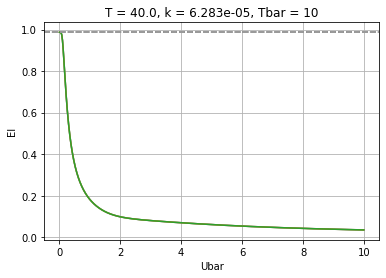

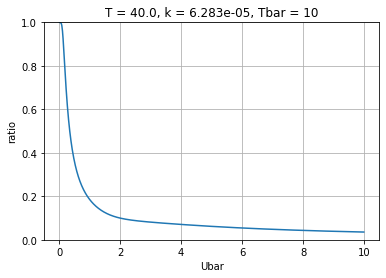

In [40]:
fig, ax = plt.subplots(1,1)
El.plot();El_10.plot();El_100.plot();
ax.axhline(Ee.values,c='k',linestyle='--')
ax.axhline(Ee_10.values,c='grey',linestyle='--')
ax.axhline(Ee_100.values,c='darkgrey',linestyle='--')
ax.grid()

fig, ax = plt.subplots(1,1)
ratio.plot()
ax.grid()
ax.set_ylim(0,1)

In [42]:
T = 10. # days

ds = xr.Dataset(dict(T=T, k=k, Ubar=("x", Ubar), Tbar=Tbar))
# x is here for technical reasons and may represent lon, lat for instance
ds = ds.chunk(dict(x=10)) # dask test

#out = get_lagrangian_energy_loss(omega, bandwidth, ds,full_output=True)
Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, ds,_factor_tau_max=10)
ratio = ratio.swap_dims(dict(x="Ubar"))
El = El.swap_dims(dict(x="Ubar")).compute()

Ee_10,El_10,ratio_10 = get_lagrangian_energy_loss(omega, bandwidth, ds,_factor_tau_max=10)
ratio_10 = ratio_10.swap_dims(dict(x="Ubar"))
El_10 = El_10.swap_dims(dict(x="Ubar")).compute()

Ee_100,El_100,ratio_100 = get_lagrangian_energy_loss(omega, bandwidth, ds)
ratio_100 = ratio_100.swap_dims(dict(x="Ubar"))
El_100 = El_100.swap_dims(dict(x="Ubar")).compute()

(0.0, 1.0)

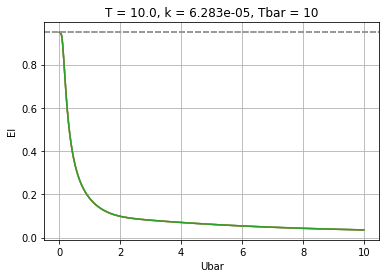

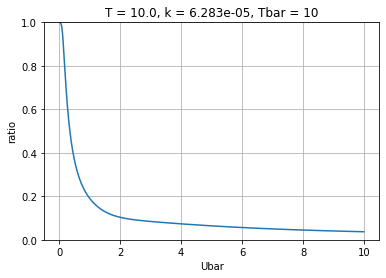

In [43]:
fig, ax = plt.subplots(1,1)
El.plot();El_10.plot();El_100.plot();
ax.axhline(Ee.values,c='k',linestyle='--')
ax.axhline(Ee_10.values,c='grey',linestyle='--')
ax.axhline(Ee_100.values,c='darkgrey',linestyle='--')
ax.grid()

fig, ax = plt.subplots(1,1)
ratio.plot()
ax.grid()
ax.set_ylim(0,1)

In [44]:
T = 2. # days

ds = xr.Dataset(dict(T=T, k=k, Ubar=("x", Ubar), Tbar=Tbar))
# x is here for technical reasons and may represent lon, lat for instance
ds = ds.chunk(dict(x=10)) # dask test

#out = get_lagrangian_energy_loss(omega, bandwidth, ds,full_output=True)
Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, ds,_factor_tau_max=10)
ratio = ratio.swap_dims(dict(x="Ubar"))
El = El.swap_dims(dict(x="Ubar")).compute()

Ee_10,El_10,ratio_10 = get_lagrangian_energy_loss(omega, bandwidth, ds,_factor_tau_max=10)
ratio_10 = ratio_10.swap_dims(dict(x="Ubar"))
El_10 = El_10.swap_dims(dict(x="Ubar")).compute()

Ee_100,El_100,ratio_100 = get_lagrangian_energy_loss(omega, bandwidth, ds)
ratio_100 = ratio_100.swap_dims(dict(x="Ubar"))
El_100 = El_100.swap_dims(dict(x="Ubar")).compute()

(0.0, 1.0)

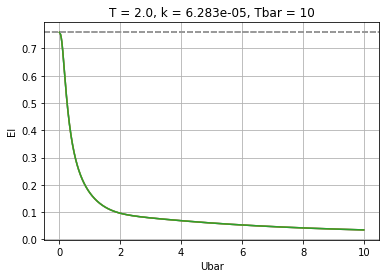

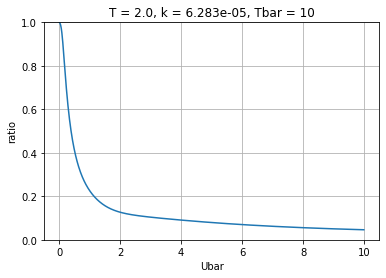

In [45]:
fig, ax = plt.subplots(1,1)
El.plot();El_10.plot();El_100.plot();
ax.axhline(Ee.values,c='k',linestyle='--')
ax.axhline(Ee_10.values,c='grey',linestyle='--')
ax.axhline(Ee_100.values,c='darkgrey',linestyle='--')
ax.grid()

fig, ax = plt.subplots(1,1)
ratio.plot()
ax.grid()
ax.set_ylim(0,1)

#### Notes on decorrelation timescale : 
1) No significant impact on Lagrangian estimation (dominant parameter is the slow motion variance)

2) Impact on the Eulerian estimation, the lower the timescale, the lower the estimation is (even for T=10d which should have been ok)

#### Notes on tau max :

No impact (no need to take too much)

#### LLC4320

In [46]:
root_path = '/Users/zcaspar/codes/mit4320/'
ds_low = xr.open_dataset(root_path+'energy_binned_dl2.0.nc')
ds_low_var = xr.open_dataset(root_path+'variance_binned_dl2.0.nc')

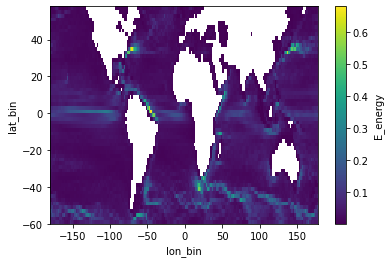

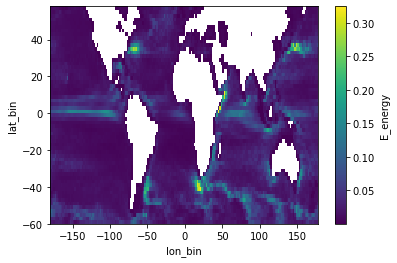

In [47]:
ds_low.E_energy.plot(y='lat_bin')
plt.figure()
ds_low_var.E_energy.plot(y='lat_bin')

In [51]:
T = 10.
ds = xr.Dataset(dict(T=T, k=k, Ubar=(["lon",'lat'], ds_low.E_energy.values), Tbar=Tbar))

In [52]:
ds

<xarray.Dataset>
Dimensions:  (lon: 179, lat: 59)
Dimensions without coordinates: lon, lat
Data variables:
    T        float64 10.0
    k        float64 6.283e-05
    Ubar     (lon, lat) float64 0.06113 0.05869 0.1261 ... 0.0176 0.01344
    Tbar     int64 10

In [56]:
Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, ds, _factor_tau_max=10)
#ratio = get_lagrangian_energy_loss(omega, bandwidth, ds, _factor_dtau=100, _factor_tau_max=100)
#ratio = ratio.swap_dims(dict(x="Ubar"))
#El = El.swap_dims(dict(x="Ubar"))

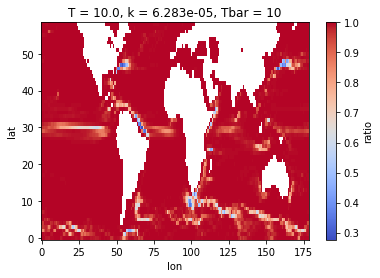

In [57]:
ratio.plot(y='lat',cmap='coolwarm',)

In [187]:
root_path = '/Users/zcaspar/codes/mit4320/'
#low :
file_E = root_path +'binned_Ecov_low_dl2.nc'
file_L = root_path +'binned_Lcov_low_dl2_flag10.nc'

dsE_low = xr.open_dataset(file_E)
dsL_low = xr.open_dataset(file_L)
#low_dl2 = xr.open_dataset(root_path+'variance_binned_dl2.0.nc').rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'}) # Energy, 2°bins
low_dl2 = xr.open_dataset(root_path+'energy_binned_dl2.0.nc').rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'}) # Energy, 2°bins

#tide
file_E = root_path +'binned_Ecov_uu_dl2.nc'
file_L = root_path +'binned_Lcov_uu_dl2_flag10.nc'
file_L_T80 = root_path +'binned_Lcov_uu_dl2_flag10_T80.nc'
dsE = xr.open_dataset(file_E)
dsL = xr.open_dataset(file_L)
dsE_SSV = xr.open_dataset(root_path +'binned_Ecov_vv_dl2.nc')
dsL_SSV = xr.open_dataset(root_path +'binned_Lcov_vv_dl2_flag10.nc')

dsL_80 = xr.open_dataset(file_L_T80)
hf_dl1 = xr.merge([xr.open_dataset(root_path+'energy_%s_binned_dl1.0.nc'% i).rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'}
                                                                                   ) for i in ['SSU','SSV']])
hf_dl2 = xr.open_dataset(root_path+'energy_SSU_binned_dl2.0.nc').rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'})
# Tidal variance, 2°bins


#path = '/Users/zcaspar/codes/Diagnostics/'+run#local



In [188]:
low_dl2

<xarray.Dataset>
Dimensions:     (lon_bins: 179, lat_bins: 59)
Coordinates:
  * lon_bins    (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bins    (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 53.0 55.0 57.0
    E_count     (lon_bins, lat_bins) int64 ...
Data variables:
    E_energy    (lon_bins, lat_bins) float64 ...
    L_energy    (lon_bins, lat_bins) float64 ...
    waterdepth  (lon_bins, lat_bins) float64 ...
    L_count     (lon_bins, lat_bins) int64 ...

In [153]:
dt = 3/24 # time step in days
rad = 2*np.pi
tau = np.arange(0,dsL.lags.max()+dt,dt) #time lag

In [154]:
def fit_function(y,t=None,myfunc=None,first_guess='free',bounds=None,sigma=None):
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        y : data to fit
        t : timelag of the correlation function
        myfunc : function we want to fit to our data, y
        p0 : first guess on parameters
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        params : parameters for which we obtain the best fit
        error : covariance of params computed in scipy.optimize.curve_fit
        yfit : best fit
        """
    sig = signature(myfunc)
    len_sig = len(sig.parameters.keys())
    try : 
        if first_guess=='lag' and sigma is None:
            _p0 = np.full(len_sig-1,1)
            _p0[-1] = y[0]
            params,cov = scipy.optimize.curve_fit(myfunc,t,y,p0=_p0,bounds=bounds,maxfev=1000)
    #    try:
        if sigma is not None:
            if first_guess=='lag':
                _p0 = np.full(len_sig-1,1)
                _p0[-1] = y[0]
                params,cov = scipy.optimize.curve_fit(myfunc,t,y,p0=_p0,bounds=bounds,maxfev=1000,
                                                  sigma=sigma,absolute_sigma=True)
            else:
                params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds,maxfev=1000,
                                                  sigma=sigma,absolute_sigma=True)
        else:
            params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds,maxfev=1000)
        yfit = myfunc(t,*[p for p in params])
        error=np.sqrt(np.diag(cov))
    except:
        params,error = np.full(len_sig-1,np.nan),np.full(len_sig-1,np.nan)
        yfit = np.full_like(t,np.nan)
#        out = xr.Dataset({'params':(['lat_bins','lon_bins','param'],np.expand_dims(params, axis=0)),
#                      'fitted':(['lat_bins','lon_bins','lags'],np.expand_dims(yfit,axis=0)),
#                     'error' : (['lat_bins','lon_bins','param'],np.expand_dims(cov,axis=0))},
 #                    coords={'lat_bins':np.array([y.lat_bins.values]),'lon_bins':np.array([y.lon_bins.values])
 #                            ,'param':[V for V in sig.parameters.keys()][1:],
 #                            'lags':y.lags.values})
    return params,error,yfit
def wrapper(ds,v,myfunc,t,bounds,p0='free',sigma=None):
    sig = signature(myfunc)
    params_name = [V for V in sig.parameters.keys()][1:]
    kwargs={'t':t,'myfunc':myfunc,'first_guess':p0,'bounds':bounds}
    if sigma is not None:
        kwargs.update({'sigma':sigma})
        
    print('Parameters to estimate:',params_name)
    params,error,yfit = xr.apply_ufunc(fit_function,ds[v],input_core_dims=[['lags']],
                                   output_core_dims=[['param'],['param'],['lags']],
                                   vectorize=True,kwargs=kwargs)
    params = params.rename('parameters').assign_coords({'param':params_name})
    error = error.rename('error').assign_coords({'param':params_name})
    ds_out = xr.merge([params,error,yfit])
#    ds_out = ds_out.where(ds_out[v].isel(lags=0)>1e-18)
    return ds_out

In [155]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2

In [156]:
omega_sn = (omega_S2-omega_M2)/2

print('Spring-neap cycle : ', 1/(2*omega_sn), 'days')
print('Oscillation after demodulation ( spring-neap cycle /2): ', 1/omega_sn, 'days')

Spring-neap cycle :  14.765294045749723 days
Oscillation after demodulation ( spring-neap cycle /2):  29.530588091499446 days


In [157]:
def y_fit(tau,T,V):
    return V*np.exp(-tau/T)*np.cos(rad*omega_sn*tau)

def y_fit_low(tau,T,V):
    return V*np.exp(-tau/T)

In [158]:
dsE_low = dsE_low.where(dsE_low.rr.isel(lags=0)>0)
dsL_low = dsL_low.isel(lags=slice(0,None,3))

In [159]:
sigma = np.ones(tau.size)*0.5
sigma[int(20/dt):] = 5
sigma[0] = 0.1

In [160]:
dsE_low_out = wrapper(dsE_low,'rr',y_fit_low,tau,p0='lag',sigma=sigma,bounds=([1,0],[np.inf,np.inf]))
dsL_low_out = wrapper(dsL_low,'rr',y_fit_low,tau,p0='lag',sigma=sigma,bounds=([1,0],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']
Parameters to estimate: ['T', 'V']


In [161]:
dsE = dsE.where(dsE.rr.isel(lags=0)>0)
dsL = dsL.isel(lags=slice(0,None,3))

In [162]:
dsE_out = wrapper(dsE,'rr',y_fit,tau,bounds=([2.5,0],[np.inf,np.inf]))
dsL_out = wrapper(dsL,'rr',y_fit,tau,bounds=([2.5,0],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']
Parameters to estimate: ['T', 'V']


In [139]:
dsE_SSV = dsE_SSV.where(dsE.rr.isel(lags=0)>0)
dsL_SSV = dsL_SSV.isel(lags=slice(0,None,3))
dsE_out_SSV = wrapper(dsE_SSV,'rr',y_fit,tau,bounds=([2.5,0],[np.inf,np.inf]))
dsL_out_SSV = wrapper(dsL_SSV,'rr',y_fit,tau,bounds=([2.5,0],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']
Parameters to estimate: ['T', 'V']


In [163]:
low_dl2

<xarray.Dataset>
Dimensions:       (lon_bins: 179, lat_bins: 59)
Coordinates:
  * lon_bins      (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bins      (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 53.0 55.0 57.0
Data variables:
    E_count       (lon_bins, lat_bins) int64 ...
    E_energy_SSU  (lon_bins, lat_bins) float64 ...
    L_energy_SSU  (lon_bins, lat_bins) float64 ...
    waterdepth    (lon_bins, lat_bins) float64 ...
    L_count       (lon_bins, lat_bins) int64 ...

In [164]:
# Timescales
Te = dsE_out.sel(param='T').parameters.values
Tl = dsL_out.sel(param='T').parameters.values
Tlbar = dsL_low_out.sel(param='T').parameters.values
Tebar = dsE_low_out.sel(param='T').parameters.values

Ulbar = dsL_low.rr.isel(lags=0).values
Uebar = dsE_low.rr.isel(lags=0).values
#dsL_low_out.sel(param='V').parameters.values
Ubar = low_dl2.L_energy_SSU.values
U = dsE.rr.isel(lags=0).values
U_bis = hf_dl2.E_energy_SSU.values
#dsE_out.sel(param='V').parameters.values
#Ul = dsL_out.sel(param='V').parameters.values

In [141]:
Te_SSV = dsE_out_SSV.sel(param='T').parameters.values
Tl_SSV = dsL_out_SSV.sel(param='T').parameters.values
Tlbar_SSV = dsL_low_out.sel(param='T').parameters.values
Tebar_SSV = dsE_low_out.sel(param='T').parameters.values

Ulbar = dsL_low.rr.isel(lags=0).values
Uebar = dsE_low.rr.isel(lags=0).values
#dsL_low_out.sel(param='V').parameters.values
Ubar = low_dl2.E_energy.values
U = dsE.rr.isel(lags=0).values
U_bis = hf_dl2.E_energy_SSU.values

In [176]:
# wave
omega = (omega_S2+omega_M2)/2 # cpd
T = np.nanmean(Te) # days
k = 2*np.pi/100e3 # rad/m

# filter
bandwidth = 0.4 # cpd

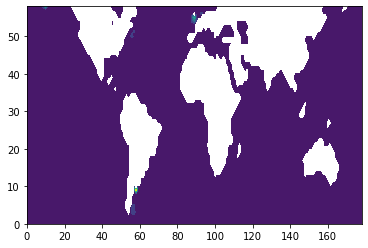

In [182]:
plt.contourf(Ubar.T)

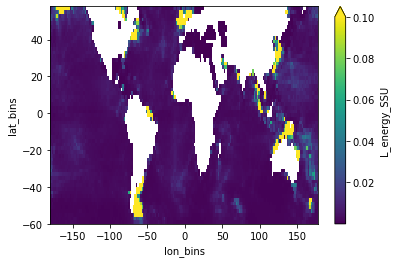

In [186]:
low_dl2.L_energy_SSU.plot(y='lat_bins',vmax=0.1
                         )

In [166]:
ds = xr.Dataset(dict(T=(["lon",'lat'],Te), k=k, Ubar=(["lon",'lat'], np.sqrt(Ubar)),
                     Tbar=(["lon",'lat'], Tlbar.T), U=(["lon",'lat'], U_bis)))

In [167]:
Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, ds, U=ds.U, _factor_tau_max=10)

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [168]:
import cartopy.crs as ccrs
def plot_maps(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111,**kwargs):
    crs = ccrs.Robinson()
    #fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y='lat_bins',ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,label=False,**kwargs,
           cbar_kwargs={'fraction':0.02})
    ax.gridlines(draw_labels=True)
    return fig,ax

In [170]:
ds_predict = xr.Dataset({'Ee':Ee,'El':El,'ratio':ratio})

In [171]:
ds_predict = ds_predict.rename({'lon':'lon_bins','lat':'lat_bins'})
ds_predict = ds_predict.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

Text(0.5, 1.0, 'Eulerian estimation ratio')

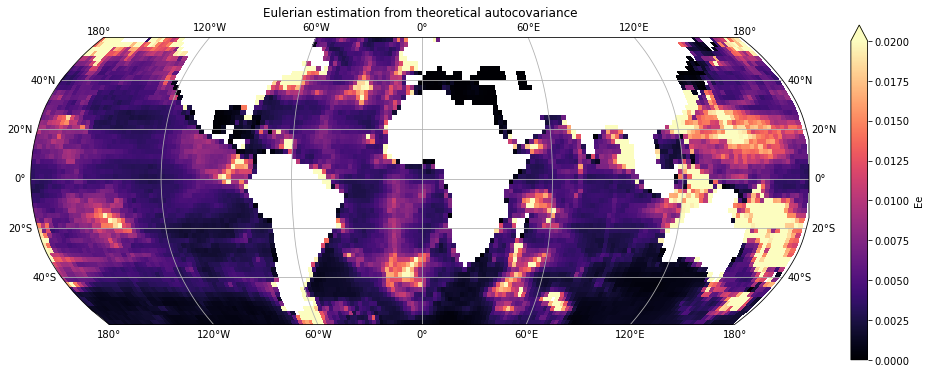

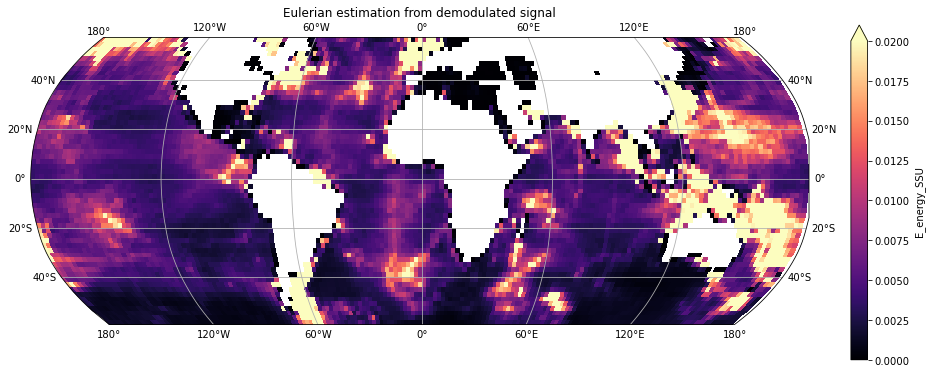

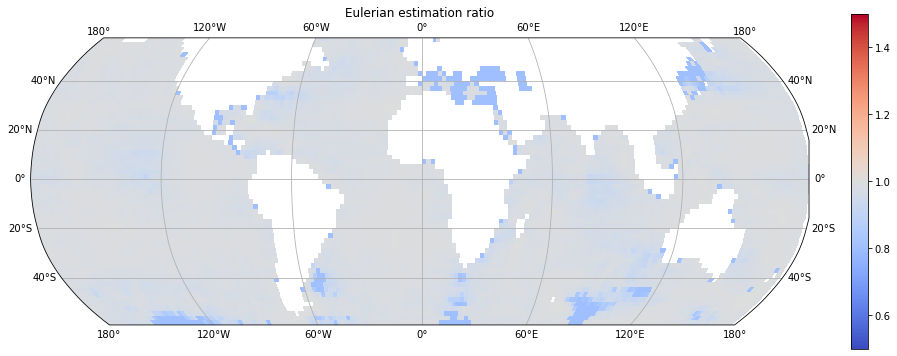

In [172]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.Ee,colmap='magma',vlim=(0,0.02))
ax.set_title('Eulerian estimation from theoretical autocovariance')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(hf_dl2.E_energy_SSU,colmap='magma',vlim=(0,0.02))
ax.set_title('Eulerian estimation from demodulated signal')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.Ee/hf_dl2.E_energy_SSU,colmap='coolwarm',vlim=(0.5,1.5))
ax.set_title('Eulerian estimation ratio')

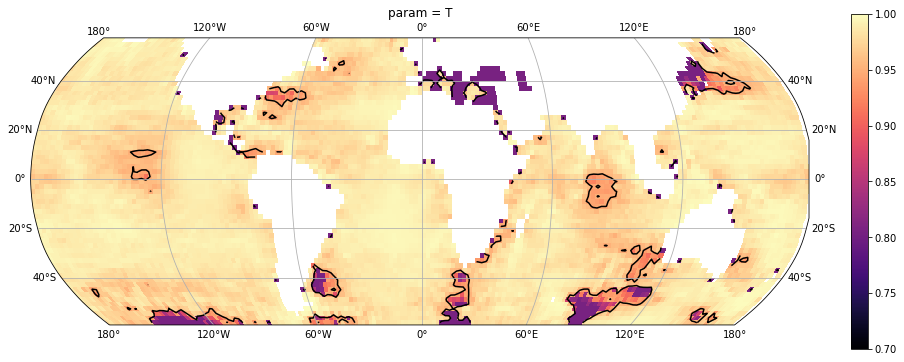

In [173]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.Ee/hf_dl2.E_energy_SSU,colmap='magma',vlim=(0.7,1.))
ax.set_title('Eulerian estimation ratio')
dsE_out.sel(param='T').parameters.plot.contour(levels=[10],ax=ax,colors='k',
                                               transform=ccrs.PlateCarree(),y='lat_bins')

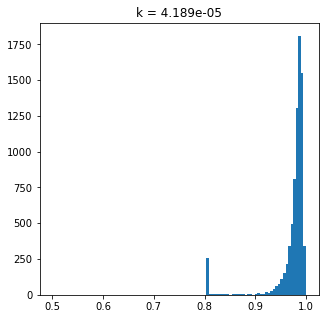

In [174]:


bins = np.linspace(0.5,1,100)
fig,axes = plt.subplots(figsize=(5,5))
_ = (ds_predict.Ee/hf_dl2.E_energy_SSU).plot.hist(bins=bins,ax=axes)



#### Notes : 

Underestimation of Eulerian variance in some areas (small timescales)

Text(0.5, 1.0, 'Lagrangian estimation ratio')

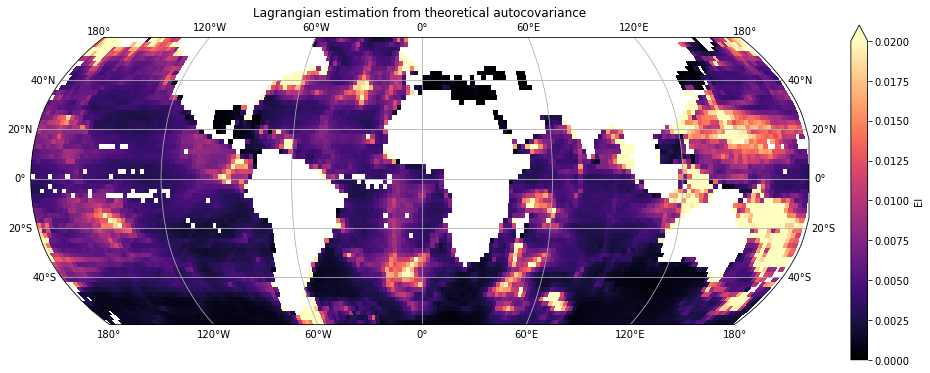

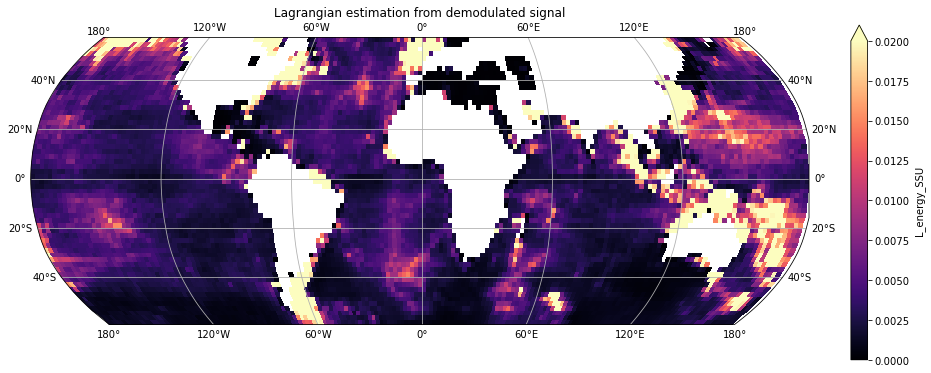

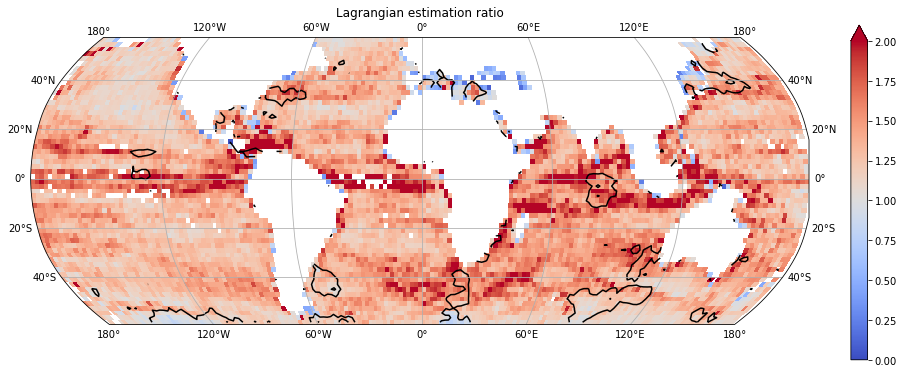

In [175]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.El,colmap='magma',vlim=(0,0.02))
ax.set_title('Lagrangian estimation from theoretical autocovariance')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(hf_dl2.L_energy_SSU,colmap='magma',vlim=(0,0.02))
ax.set_title('Lagrangian estimation from demodulated signal')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.El/hf_dl2.L_energy_SSU,colmap='coolwarm',vlim=(0,2))
dsE_out.sel(param='T').parameters.plot.contour(levels=[10],ax=ax,colors='k',
                                               transform=ccrs.PlateCarree(),y='lat_bins')

ax.set_title('Lagrangian estimation ratio')

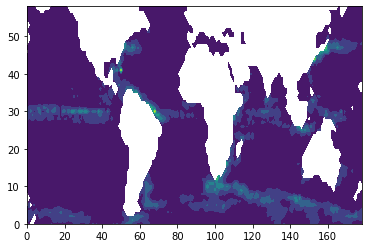

In [138]:
plt.contourf(Ulbar)

#### Test cells

In [138]:
dsE_pred = xr.Dataset(dict(T=(["lon",'lat'],Te), k=k, Ubar=(["lon",'lat'], np.sqrt(Uebar)),
                     Tbar=(["lon",'lat'], Tebar), U=(["lon",'lat'], U)))

dsL_pred_v2 = xr.Dataset(dict(T=(["lon",'lat'],Te), k=k, Ubar=(["lon",'lat'], np.sqrt(Ulbar.T)),
                     Tbar=(["lon",'lat'], Tlbar.T), U=(["lon",'lat'], U)))

dsL_pred_v3 = xr.Dataset(dict(T=(["lon",'lat'],Te), k=k, Ubar=(["lon",'lat'], np.sqrt(Ulbar.T)),
                     Tbar=(["lon",'lat'], Tlbar.T), U=(["lon",'lat'], U_bis)))

In [139]:
Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, dsE_pred, U=dsE_pred.U)

In [106]:
Ee_v2,El_v2,ratio_v2 = get_lagrangian_energy_loss(omega, bandwidth, dsL_pred_v2, U=dsL_pred_v2.U)

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [107]:
Ee_v3,El_v3,ratio_v3 = get_lagrangian_energy_loss(omega, bandwidth, dsL_pred_v3, U=dsL_pred_v3.U)

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [141]:
ds_predict = xr.Dataset({'Ee':Ee,'El':El,'ratio':ratio})
ds_predict_v2 = xr.Dataset({'Ee':Ee_v2,'El':El_v2,'ratio':ratio_v2})
ds_predict_v3 = xr.Dataset({'Ee':Ee_v3,'El':El_v3,'ratio':ratio_v3})
ds_predict

<xarray.Dataset>
Dimensions:  (lon: 179, lat: 59)
Coordinates:
    T        (lon, lat) float64 22.08 28.25 25.03 49.48 ... 73.3 36.65 71.84
    k        float64 6.283e-05
    Ubar     (lon, lat) float64 0.1442 0.1707 0.2903 ... 0.1142 0.1224 0.1005
    Tbar     (lon, lat) float64 7.559 5.278 9.05 9.892 ... 3.554 6.43 8.81 7.332
Dimensions without coordinates: lon, lat
Data variables:
    Ee       (lon, lat) float64 0.0004122 0.0003483 ... 0.004912 0.005193
    El       (lon, lat) float64 0.0003679 0.0002911 ... 0.004617 0.005061
    ratio    (lon, lat) float64 0.8925 0.8357 0.5837 ... 0.9561 0.9398 0.9746

In [142]:
ds_predict = ds_predict.rename({'lon':'lon_bins','lat':'lat_bins'})
ds_predict = ds_predict.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

ds_predict_v2 = ds_predict_v2.rename({'lon':'lon_bins','lat':'lat_bins'})
ds_predict_v2 = ds_predict_v2.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

ds_predict_v3 = ds_predict_v3.rename({'lon':'lon_bins','lat':'lat_bins'})
ds_predict_v3 = ds_predict_v3.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

(<Figure size 1080x1080 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'k = 6.283e-05, lags = 0.0'}, xlabel='lon_bins', ylabel='lat_bins'>)

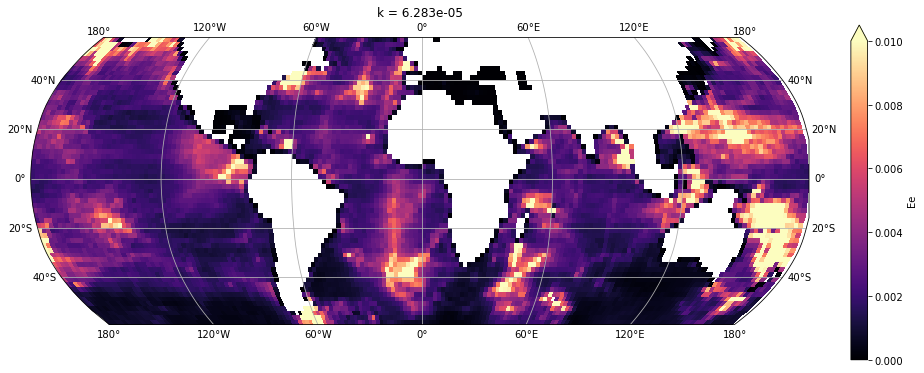

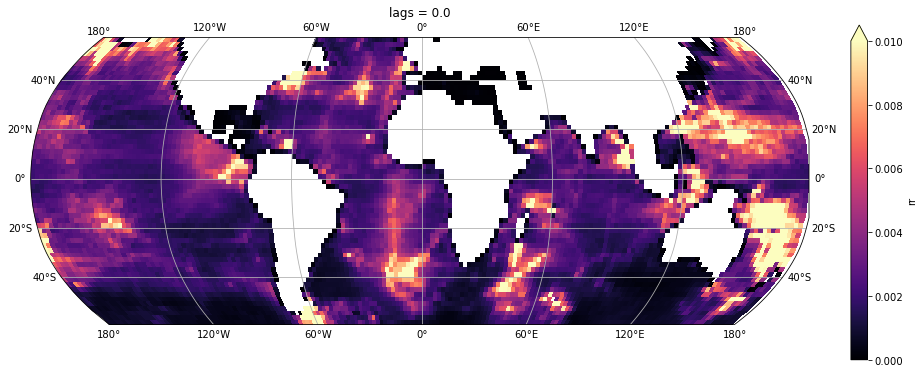

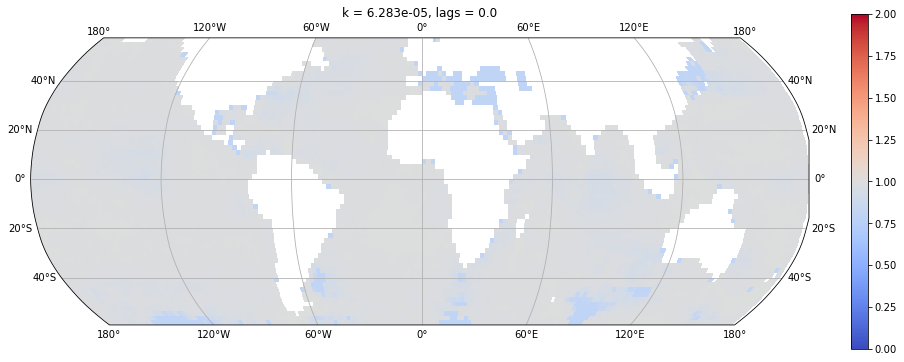

In [143]:
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict.Ee,colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(dsE.rr.isel(lags=0),colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict.Ee/dsE.rr.isel(lags=0),colmap='coolwarm',vlim=(0,2))

(<Figure size 1080x1080 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'k = 6.283e-05, lags = 0.0'}, xlabel='lon_bins', ylabel='lat_bins'>)

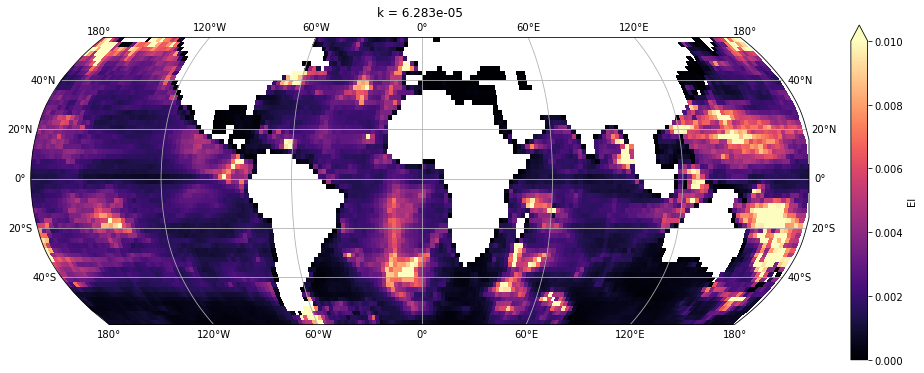

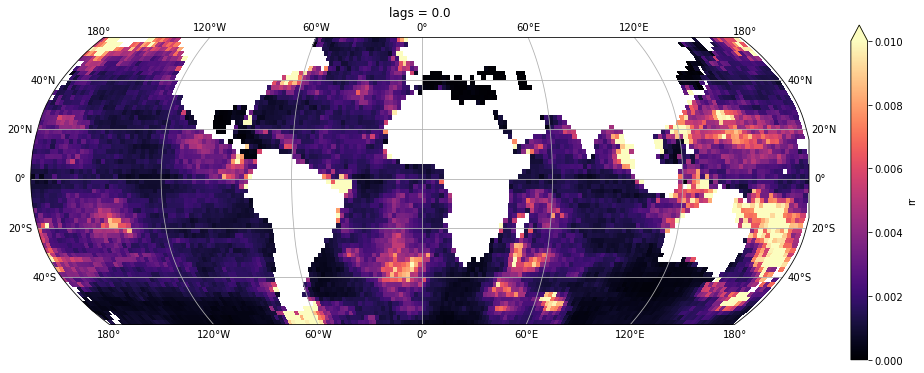

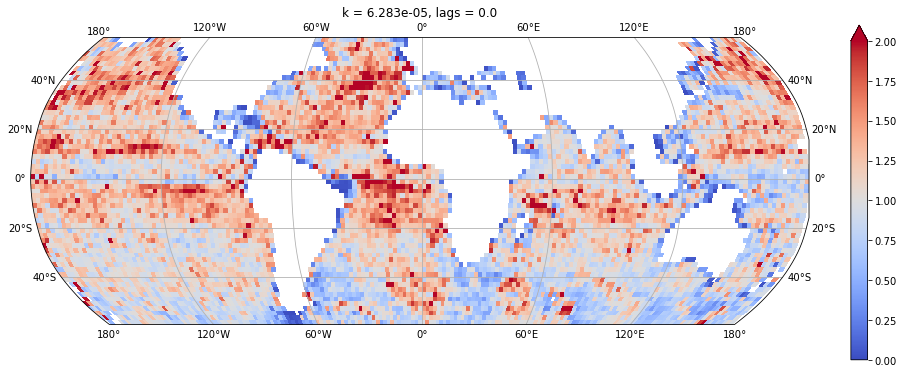

In [144]:
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict.El,colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(dsL.rr.isel(lags=0),colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict.El/dsL.rr.isel(lags=0),colmap='coolwarm',vlim=(0,2))

(<Figure size 1080x1080 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'k = 6.283e-05, lags = 0.0'}, xlabel='lon_bins', ylabel='lat_bins'>)

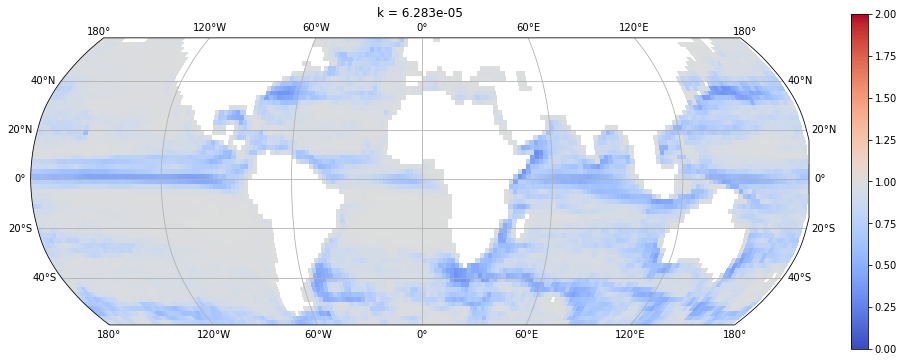

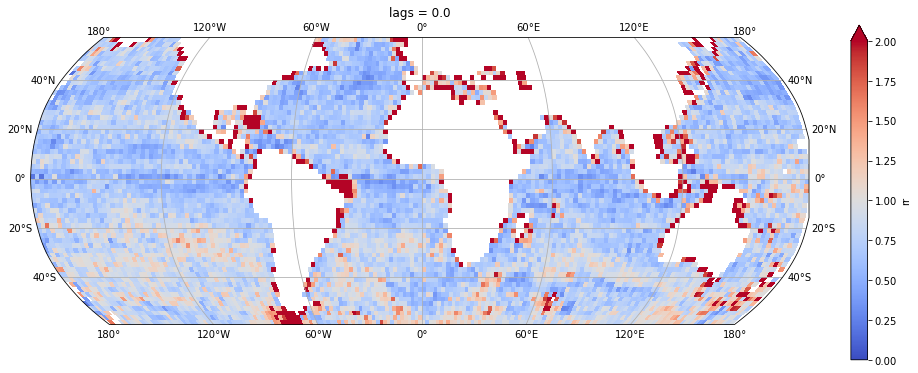

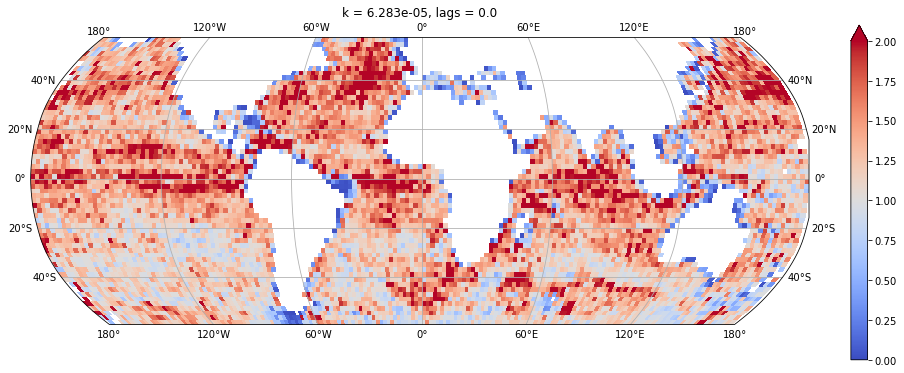

In [145]:
fig = plt.figure(figsize=(15,15))
plot_maps(ds_predict.El/ds_predict.Ee,colmap='coolwarm',vlim=(0,2))
fig = plt.figure(figsize=(15,15))
plot_maps(dsL.rr.isel(lags=0)/dsE.rr.isel(lags=0),colmap='coolwarm',vlim=(0,2))
fig = plt.figure(figsize=(15,15))
plot_maps((ds_predict.El*dsE.rr.isel(lags=0))/(ds_predict.El*dsL.rr.isel(lags=0)),colmap='coolwarm',vlim=(0,2))

In [114]:
### Third version

(<Figure size 1080x1080 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'k = 6.283e-05'}, xlabel='lon_bins', ylabel='lat_bins'>)

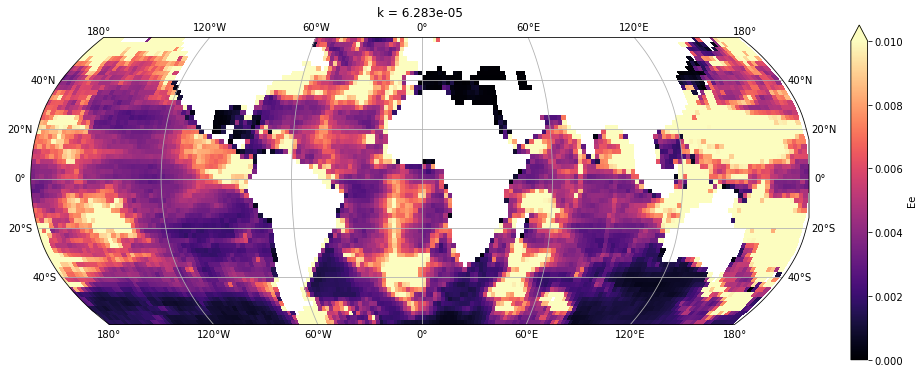

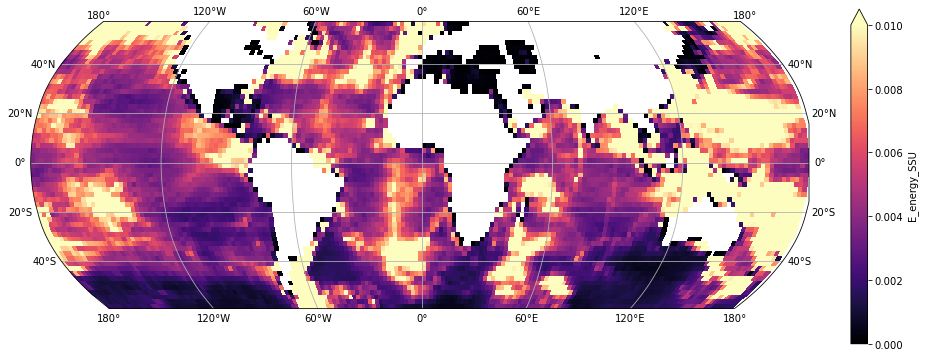

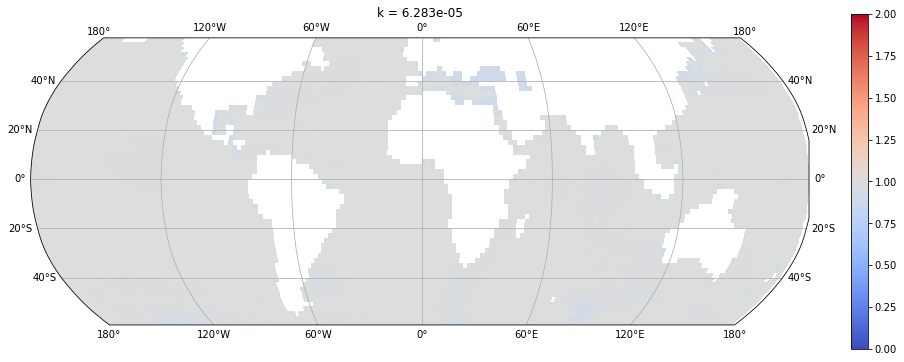

In [115]:
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict_v3.Ee,colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(hf_dl2.E_energy_SSU,colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict_v3.Ee/hf_dl2.E_energy_SSU,colmap='coolwarm',vlim=(0,2))

(<Figure size 1080x1080 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'k = 6.283e-05'}, xlabel='lon_bins', ylabel='lat_bins'>)

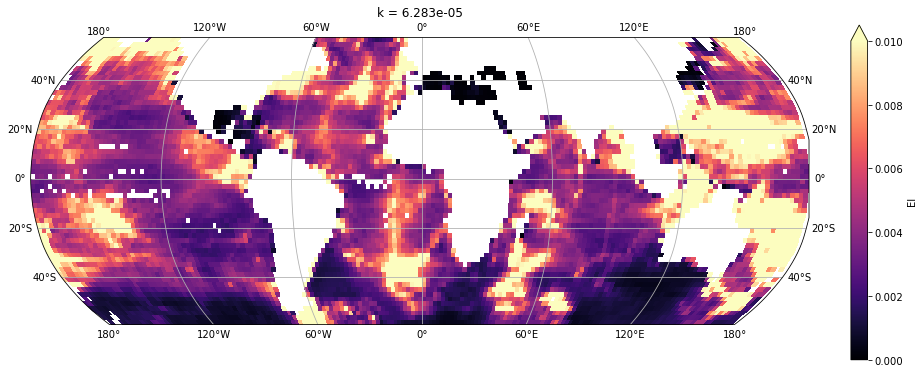

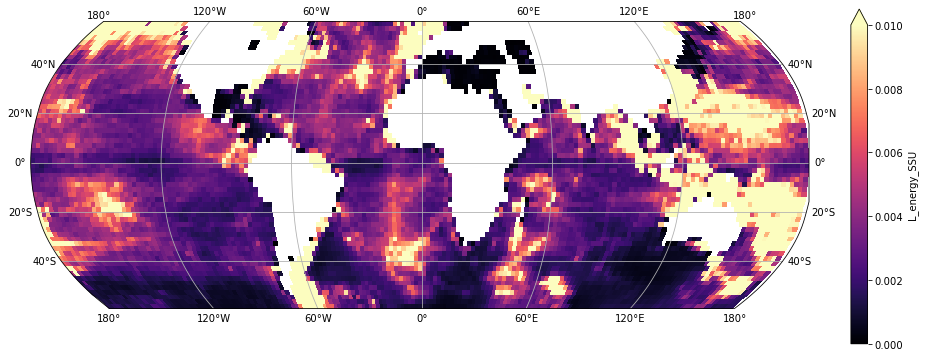

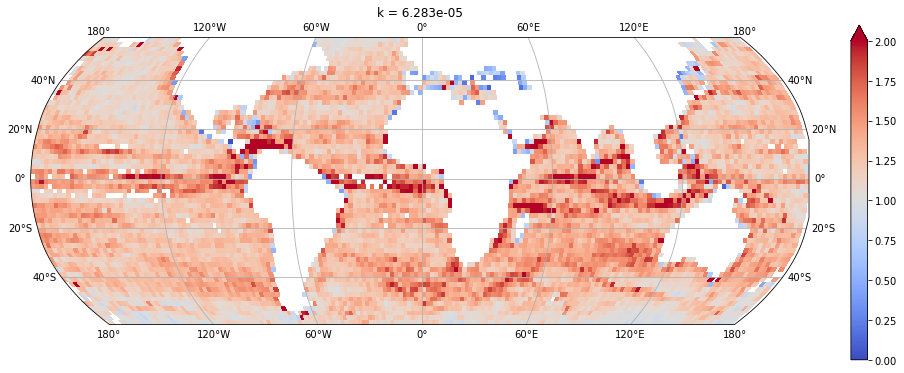

In [116]:
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict_v3.El,colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(hf_dl2.L_energy_SSU,colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict_v3.El/hf_dl2.L_energy_SSU,colmap='coolwarm',vlim=(0,2))

(<Figure size 1080x1080 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'k = 6.283e-05'}, xlabel='lon_bins', ylabel='lat_bins'>)

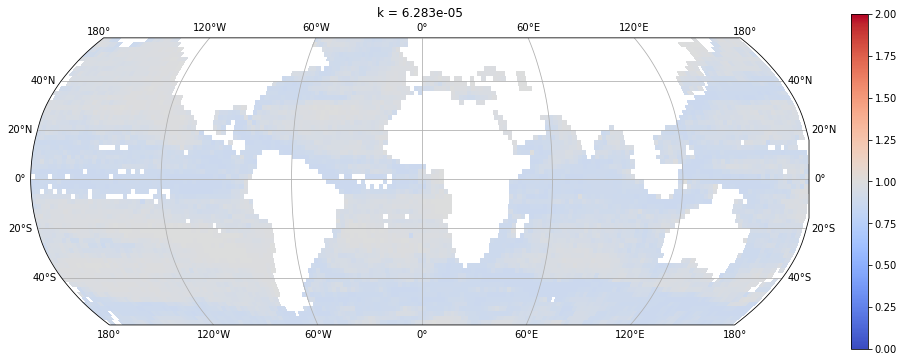

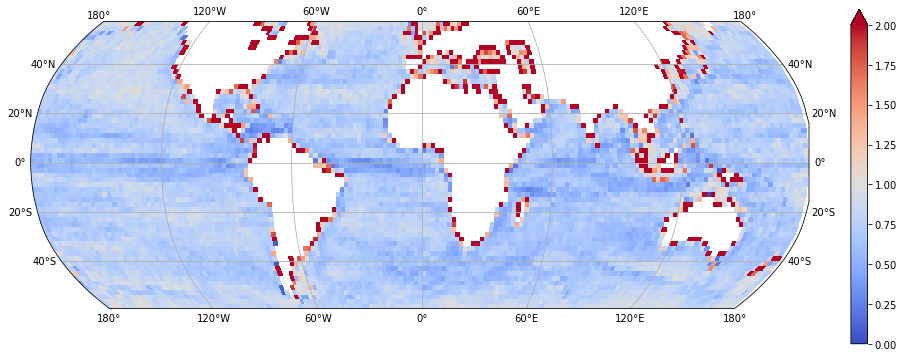

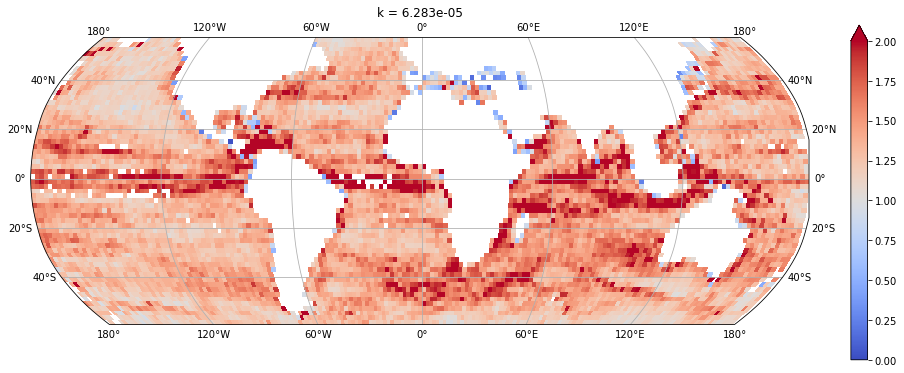

In [117]:
fig = plt.figure(figsize=(15,15))
plot_maps(ds_predict_v3.El/ds_predict_v3.Ee,colmap='coolwarm',vlim=(0,2))
fig = plt.figure(figsize=(15,15))
plot_maps(hf_dl2.L_energy_SSU/hf_dl2.E_energy_SSU,colmap='coolwarm',vlim=(0,2))
fig = plt.figure(figsize=(15,15))
plot_maps((ds_predict_v3.El*hf_dl2.E_energy_SSU)/(ds_predict_v3.El*hf_dl2.L_energy_SSU),colmap='coolwarm',vlim=(0,2))

(<Figure size 1080x1080 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'k = 6.283e-05, lags = 0.0'}, xlabel='lon_bins', ylabel='lat_bins'>)

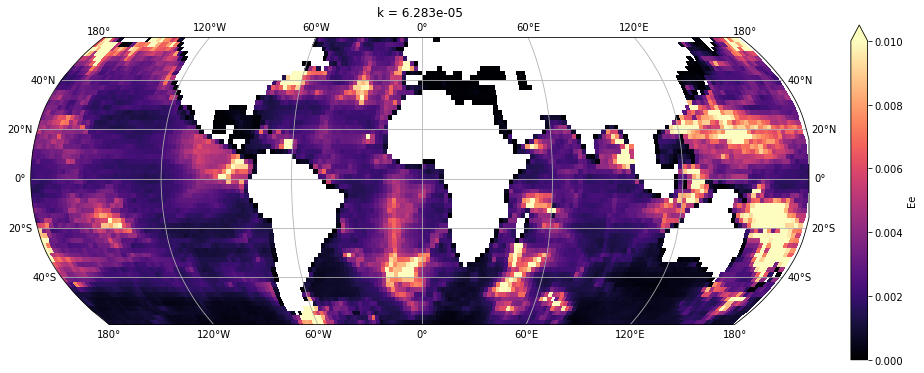

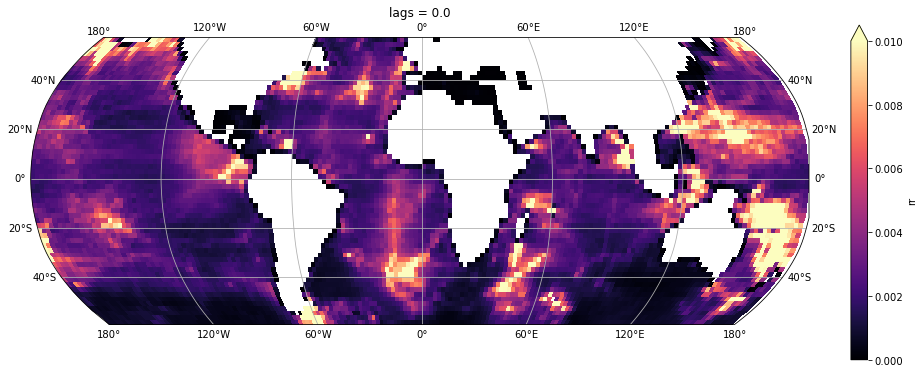

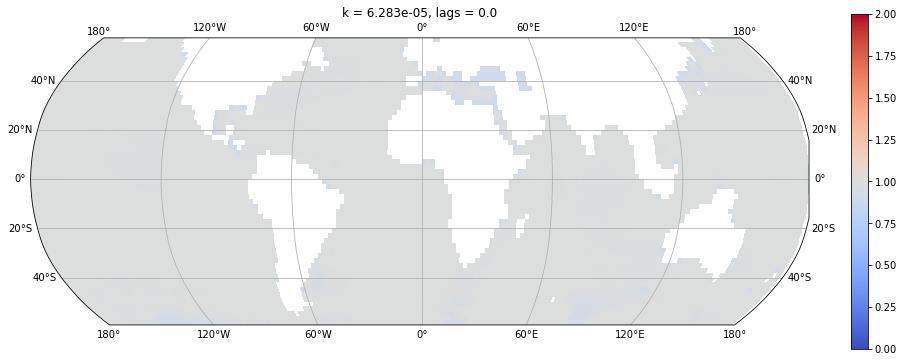

In [118]:
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict_v2.Ee,colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(dsE.rr.isel(lags=0),colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict_v2.Ee/dsE.rr.isel(lags=0),colmap='coolwarm',vlim=(0,2))

(<Figure size 1080x1080 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'k = 6.283e-05, lags = 0.0'}, xlabel='lon_bins', ylabel='lat_bins'>)

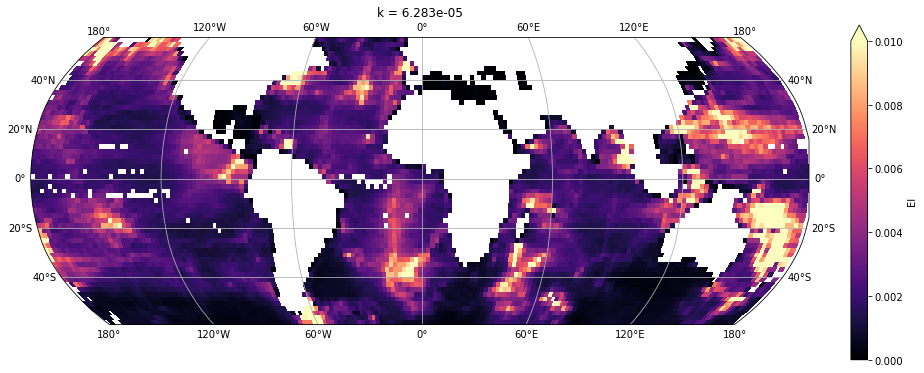

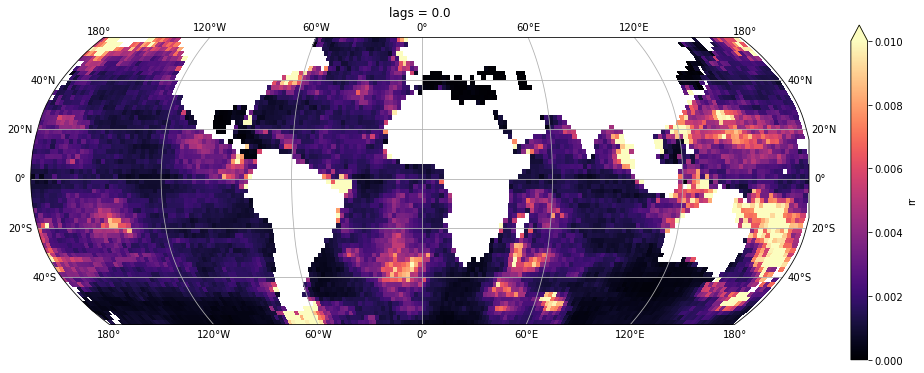

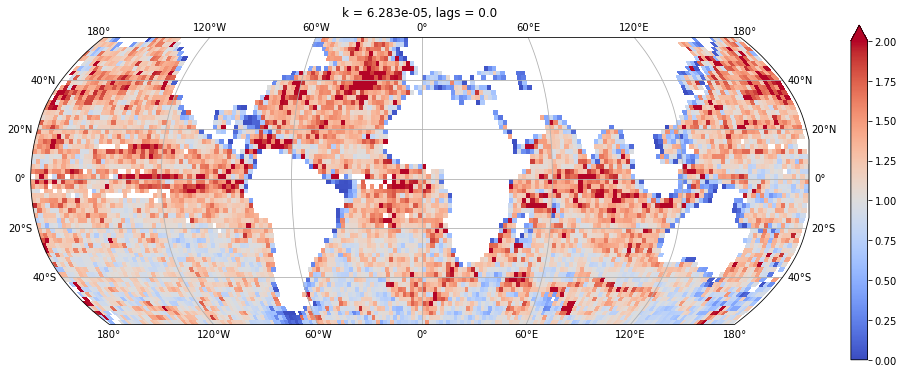

In [78]:
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict_v2.El,colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(dsL.rr.isel(lags=0),colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict_v2.El/dsL.rr.isel(lags=0),colmap='coolwarm',vlim=(0,2))

(<Figure size 1080x1080 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'k = 6.283e-05, lags = 0.0'}, xlabel='lon_bins', ylabel='lat_bins'>)

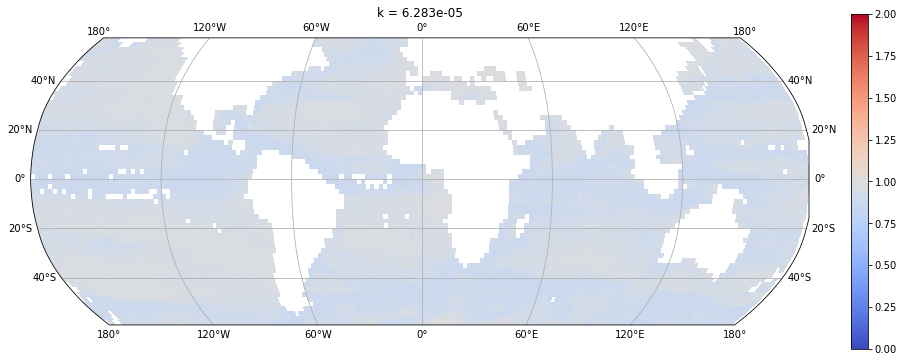

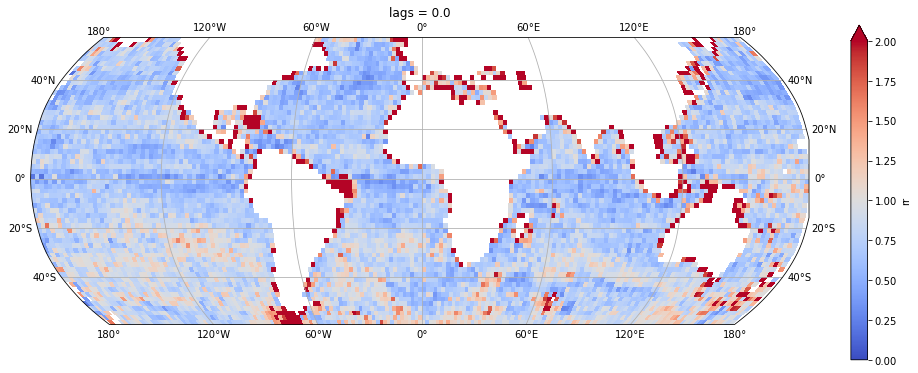

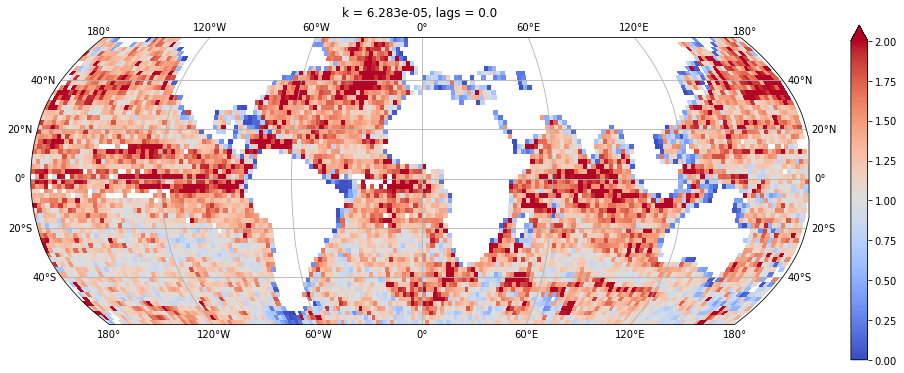

In [79]:
fig = plt.figure(figsize=(15,15))
plot_maps(ds_predict_v2.El/ds_predict_v2.Ee,colmap='coolwarm',vlim=(0,2))
fig = plt.figure(figsize=(15,15))
plot_maps(dsL.rr.isel(lags=0)/dsE.rr.isel(lags=0),colmap='coolwarm',vlim=(0,2))
fig = plt.figure(figsize=(15,15))
plot_maps((ds_predict_v2.El*dsE.rr.isel(lags=0))/(ds_predict_v2.El*dsL.rr.isel(lags=0))
          ,colmap='coolwarm',vlim=(0,2))

In [83]:
T = 20
dsL_pred_v3_bis = xr.Dataset(dict(T=(["lon",'lat'],Te), k=k, Ubar=(["lon",'lat'], np.sqrt(Ulbar.T)),
                     Tbar=(["lon",'lat'], Tlbar.T), U=(["lon",'lat'], U_bis)))

In [ ]:
Ee_bis,El_bis,ratio_bis = get_lagrangian_energy_loss(omega, bandwidth, dsL_pred_v3_bis, U=dsL_pred_v3_bis.U)

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [ ]:
ds_predict_bis = xr.Dataset({'Ee':Ee_bis,'El':El_bis,'ratio':ratio_bis})
ds_predict_bis = ds_predict_bis.rename({'lon':'lon_bins','lat':'lat_bins'})
ds_predict_bis = ds_predict_bis.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

In [ ]:
fig = plt.figure(figsize=(15,15))
plot_maps(ds_predict_bis.El/ds_predict_bis.Ee,colmap='coolwarm',vlim=(0,2))
fig = plt.figure(figsize=(15,15))
plot_maps(hf_dl2.L_energy_SSU/hf_dl2.E_energy_SSU,colmap='coolwarm',vlim=(0,2))
fig = plt.figure(figsize=(15,15))
plot_maps((ds_predict_bis.El*hf_dl2.E_energy_SSU)/(ds_predict_bis.El*hf_dl2.L_energy_SSU)
          ,colmap='coolwarm',vlim=(0,2))

In [127]:
cluster.close()